In [353]:
# !git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
# !python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
# !unzip -q COVIDTimeSeries.zip

In [416]:
    import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [417]:
# import random

# def set_seed(seed=42):
#     random.seed(seed)  # Python's built-in random module
#     np.random.seed(seed)  # NumPy
#     torch.manual_seed(seed)  # PyTorch CPU
#     torch.cuda.manual_seed(seed)  # PyTorch GPU
#     torch.cuda.manual_seed_all(seed)  # Multi-GPU
#     torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
#     torch.backends.cudnn.benchmark = False  # Disables optimization that can introduce randomness

# set_seed(42)  # Set seed for reproducibility


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [418]:
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')

/tmp/ipykernel_17393/4026236824.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  korea.index = pd.to_datetime(korea.index)


In [419]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data transformation for supervised learning data.
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

In [420]:
train_size = int(X.shape[0]*0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [421]:
test_size = int(X_test.shape[0]*0.5)
X_val, y_val = X_test[test_size:], y_test[test_size:]
X_test, y_test = X_test[:test_size], y_test[:test_size]

In [422]:
X_train.shape, X_test.shape, X_val.shape

((261, 5, 1), (33, 5, 1), (33, 5, 1))

In [423]:
MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

# MinMax scaling
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

In [424]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.sequences = data
        self.labels = labels
        
    def __len__(self):
        return len(self.sequences)
        
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

In [425]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

len(train_dataset), len(test_dataset), len(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [442]:
class CNN_LSTM(nn.Module):

    def __init__(self, n_features, n_hidden, n_layers):
        super(CNN_LSTM, self).__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    # def reset_hidden_state(self, x):
    #     self.hidden = (
    #         torch.zeros(self.n_layers, x.size(0), self.n_hidden),
    #         torch.zeros(self.n_layers, x.size(0), self.n_hidden)
    #     )

    def forward(self, x):
        batch_size = x.shape[0]

        x = x.permute(0, 2, 1)  # Swap dimensions for LSTM input
        x = self.c1(x)  # Add channel dimension
        x = x.permute(0, 2, 1)  # Swap dimensions for LSTM input
        
        h0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(x.device)
        c0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(x.device)

        lstm_out, _ = self.lstm(x)
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step)
        
        return y_pred

In [443]:
temp = next(iter(train_dataloader))[0]

In [444]:
model = CNN_LSTM(
    n_features=1,
    n_hidden=4,
    n_layers=1
)

loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [445]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # 1. Forward pass
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        # train_acc += accuracy_fn(y_pred, y)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    # train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [446]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits.squeeze(0), y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            # test_acc += accuracy_fn(test_pred_logits, y)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    # test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [447]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            # f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            # f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        # results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        # results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [448]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1106 | test_loss: 0.6233 | 
Epoch: 2 | train_loss: 0.0815 | test_loss: 0.6189 | 
Epoch: 3 | train_loss: 0.0787 | test_loss: 0.5675 | 
Epoch: 4 | train_loss: 0.0725 | test_loss: 0.4995 | 
Epoch: 5 | train_loss: 0.0607 | test_loss: 0.4329 | 
Epoch: 6 | train_loss: 0.0447 | test_loss: 0.3013 | 
Epoch: 7 | train_loss: 0.0362 | test_loss: 0.2553 | 
Epoch: 8 | train_loss: 0.0370 | test_loss: 0.2406 | 
Epoch: 9 | train_loss: 0.0353 | test_loss: 0.2280 | 
Epoch: 10 | train_loss: 0.0346 | test_loss: 0.2138 | 
Epoch: 11 | train_loss: 0.0348 | test_loss: 0.2154 | 
Epoch: 12 | train_loss: 0.0353 | test_loss: 0.2011 | 
Epoch: 13 | train_loss: 0.0337 | test_loss: 0.2015 | 
Epoch: 14 | train_loss: 0.0347 | test_loss: 0.2266 | 
Epoch: 15 | train_loss: 0.0335 | test_loss: 0.2061 | 
Epoch: 16 | train_loss: 0.0333 | test_loss: 0.1884 | 
Epoch: 17 | train_loss: 0.0341 | test_loss: 0.1972 | 
Epoch: 18 | train_loss: 0.0341 | test_loss: 0.2008 | 
Epoch: 19 | train_loss: 0.0341 | test

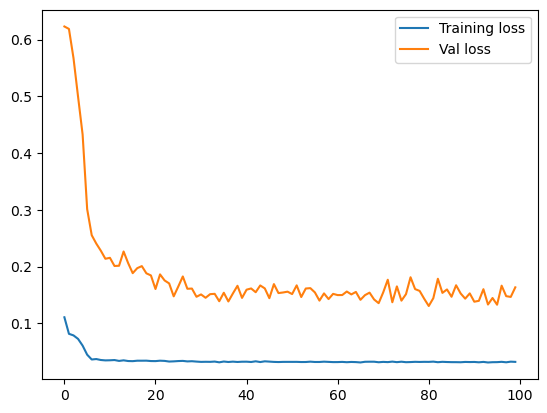

In [453]:
plt.plot(model_0_results["train_loss"], label="Training loss")
plt.plot(model_0_results["test_loss"], label="Val loss")
plt.legend()

In [454]:
def predict(sample):
    model.eval()
    
    with torch.inference_mode():
    
        y_pred = model(sample)
        # pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
        # pred_prob = torch.sigmoid(pred_logits.squeeze())

        return y_pred

In [455]:
preds = []
for X, y in val_dataloader:
    y_pred = predict(X)
    preds.append(y_pred.flatten().item())
    

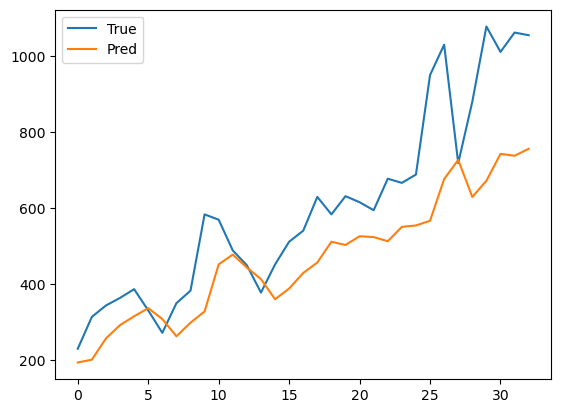

In [456]:
plt.plot(np.array([i[1].flatten().item() for i in val_dataloader])*MAX, label = 'True')
plt.plot(np.array(preds)*MAX, label = 'Pred')
plt.legend()

In [437]:
# class CNN_LSTM(nn.Module):
#     def __init__(self, n_features, n_hidden, seq_len, n_layers):
#         super(CNN_LSTM, self).__init__()
#         self.n_hidden = n_hidden
#         self.seq_len = seq_len
#         self.n_layers = n_layers

#         self.c1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=2, stride=1)
        
#         self.lstm = nn.LSTM(
#             input_size=n_features,  # Adjusted for Conv1D reduction
#             hidden_size=n_hidden,
#             num_layers=n_layers,
#             batch_first=True
#         )

#         self.linear = nn.Linear(in_features=n_hidden, out_features=1)

#     def forward(self, sequences):
#         batch_size = sequences.shape[0]

#         # Conv1D expects (batch, channels, seq_len), LSTM expects (batch, seq_len, features)
#         sequences = sequences.permute(0, 2, 1)  # Swap dimensions for LSTM input
#         # sequences = self.c1(sequences.view(batch_size, 1, -1))  # Add channel dimension
#         sequences = self.c1(sequences)  # Add channel dimension
#         sequences = sequences.permute(0, 2, 1)  # Swap dimensions for LSTM input
        
#         # Initialize hidden state dynamically
#         h_0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(sequences.device)
#         c_0 = torch.zeros(self.n_layers, batch_size, self.n_hidden).to(sequences.device)

#         lstm_out, _ = self.lstm(sequences, (h_0, c_0))

#         # Take last timestep output
#         last_time_step = lstm_out[:, -1, :]
#         y_pred = self.linear(last_time_step)
#         return y_pred